In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import h5py
import math
import timm
import torch
import torchvision.transforms as T
import random
import seaborn as sns
import subprocess
import pickle
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, recall_score
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
folder_path= "/data_g1/AI_projects/raw_data/PCITB_CRC"

/data_g2/home/jantao/deepspot-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def preprocess(folder_path):    
    # Load metadata
    map_path = os.path.join(folder_path, "map_fnms_TMAcoor_tumorIDs_level1_16_rmYALE.csv")
    map_df = pd.read_csv(map_path)
    gt_path = os.path.join(folder_path, "data_he20190613.csv")
    gt_df = pd.read_csv(gt_path)

    # Align tumor IDs and labels
    map_df["tumor"] = map_df["tumor"].astype(str)
    gt_df["TumorID"] = gt_df["TumorID"].astype(str)
    map_df_filtered = map_df[map_df["tumor"].isin(gt_df["TumorID"])].copy()

    aligned_df = map_df_filtered.merge(
        gt_df[["TumorID", "msin"]],
        left_on="tumor",
        right_on="TumorID",
        how="left"
    ).drop(columns=["TumorID"])

    aligned_df["fnm"] = aligned_df["fnm"].str.replace(r"\.txt$", "", regex=True)
    aligned_df = aligned_df.dropna(how="any")

    # Unique patients + labels
    patients = aligned_df["tumor"].unique()
    labels = aligned_df.groupby("tumor")["msin"].first().loc[patients]

    # Split patients into train/test
    train_patients, test_patients = train_test_split(
        patients,
        test_size=0.2,
        stratify=labels,
        random_state=42
    )

    # Build stratified folds on train patients only
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_labels = labels.loc[train_patients]

    folds = []
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(train_patients, train_labels)):
        fold_train_patients = train_patients[train_idx]
        fold_val_patients   = train_patients[val_idx]

        folds.append({
            "train_patients": fold_train_patients,
            "val_patients": fold_val_patients
        })

        print(f"Fold {fold_idx+1}: train {len(fold_train_patients)} patients, "
              f"val {len(fold_val_patients)} patients")

    print(f"Hold-out test set: {len(test_patients)} patients")
    
    with open("/home/jantao/MSI_prediction/preprocessed_data.pkl", "wb") as f:
        pickle.dump({
            "folds": folds,
            "test_patients": test_patients,
            "aligned_df": aligned_df
        }, f)
        
    return

In [36]:
preprocess(folder_path)

Fold 1: train 580 patients, val 145 patients
Fold 2: train 580 patients, val 145 patients
Fold 3: train 580 patients, val 145 patients
Fold 4: train 580 patients, val 145 patients
Fold 5: train 580 patients, val 145 patients
Hold-out test set: 182 patients


In [ ]:
# bash, command line, trident-env
python trident/run_batch_of_slides.py --gpu 1 --task all --wsi_dir /data_g1/AI_projects/raw_data/PCITB_CRC/HE_raw_images/Tumor --job_dir /home/jantao/MSI_prediction/conch_patches --reader_type image --patch_size 256 --search_nested

In [14]:
# feature aggregation
features_dir= "/home/jantao/MSI_prediction/conch_patches/20x_256px_0px_overlap/features_conch_v15"
slide_to_patient= os.path.join(folder_path, "map_fnms_TMAcoor_tumorIDs_level1_16_rmYALE.csv")
slide_to_patient= pd.read_csv(slide_to_patient)
patient_to_msi= os.path.join(folder_path, "data_he20190613.csv")
patient_to_msi= pd.read_csv(patient_to_msi)
df = slide_to_patient.merge(patient_to_msi, 
                            left_on="tumor", 
                            right_on="TumorID", 
                            how="left")
df= df.dropna(subset= ["msin"])
patient_features = {}

for patient_id, group in tqdm(df.groupby("tumor")):
    features_list = []
    
    for _, row in group.iterrows():
        slide_id = row["data_id"]
        feature_path = os.path.join(features_dir, f"{slide_id}.h5")
        
        if os.path.exists(feature_path):
            with h5py.File(feature_path, "r") as f:
                feats = f["features"][:]
                features_list.append(feats)
    
    if features_list:
        # aggregate across slides (e.g., mean pooling)
        patient_features[patient_id] = np.mean(np.vstack(features_list), axis=0)
        #patient_features[patient_id] = np.max(np.vstack(features_list), axis=0)
        #patient_features[patient_id] = np.min(np.vstack(features_list), axis=0)

out_path= "/home/jantao/MSI_prediction/conch_patches/mean_patient_features.h5"
with h5py.File(out_path, "w") as f:
    for patient_id, feats in patient_features.items():
        f.create_dataset(str(patient_id), data=feats)

100%|████████████████████████████████████████████████████████████████████████████████| 907/907 [00:01<00:00, 619.63it/s]


In [15]:
with open("/home/jantao/MSI_prediction/preprocessed_data.pkl", "rb") as f:
    split_data = pickle.load(f)

folds = split_data["folds"]
test_patients = split_data["test_patients"]
aligned_df = split_data["aligned_df"]
test_patients = [int(p) for p in test_patients]
for fold in folds:
    fold["train_patients"] = [int(p) for p in fold["train_patients"]]
    fold["val_patients"]   = [int(p) for p in fold["val_patients"]]
# Get patient labels from aligned_df
patient_labels = aligned_df.groupby("tumor")["msin"].first()
#patient_features = {patient_id: feature_vector}
patient_features = {int(k): v for k, v in patient_features.items()}
patient_labels   = {int(k): v for k, v in patient_labels.items()}
# ---------- Build test set ----------
X_test, y_test = [], []
for p in test_patients:
    X_test.append(patient_features[p])
    y_test.append(patient_labels[p])

X_test = np.array(X_test)
y_test = np.array(y_test)

# ---------- Build folds ----------
fold_data = []
for fold in folds:
    X_train, y_train, X_val, y_val = [], [], [], []
    
    # Training patients
    for p in fold["train_patients"]:
        X_train.append(patient_features[p])
        y_train.append(patient_labels[p])
    
    # Validation patients
    for p in fold["val_patients"]:
        X_val.append(patient_features[p])
        y_val.append(patient_labels[p])
    
    fold_data.append({
        "X_train": np.array(X_train),
        "y_train": np.array(y_train),
        "X_val": np.array(X_val),
        "y_val": np.array(y_val)
    })

# Example: access fold 1
fold1 = fold_data[0]
print("Fold 1 train size:", fold1["X_train"].shape, "val size:", fold1["X_val"].shape)
print("Test size:", X_test.shape)

Fold 1 train size: (580, 768) val size: (145, 768)
Test size: (182, 768)


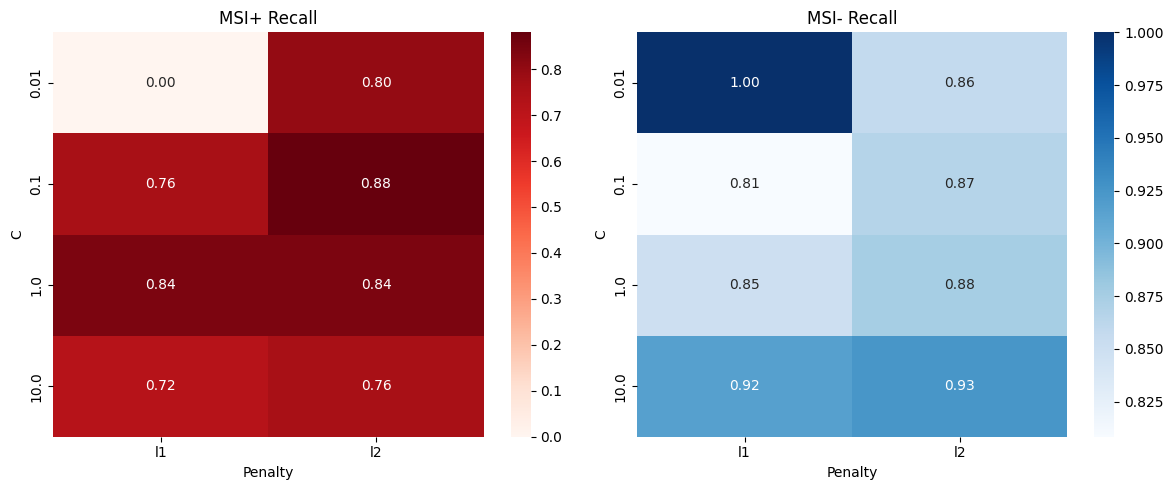

In [16]:
# logistic regression, grid search for hyperparameters
X_train_grid = fold_data[0]["X_train"]
y_train_grid = fold_data[0]["y_train"]

X_val_grid = fold_data[0]["X_val"]
y_val_grid = fold_data[0]["y_val"]

# Step 1a: Grid search on training folds
C_list = [0.01, 0.1, 1, 10]
penalties = ["l1", "l2"]

# Store recall for each combination
recall_pos = np.zeros((len(C_list), len(penalties)))  # MSI+ recall
recall_neg = np.zeros((len(C_list), len(penalties)))  # MSI- recall

for i, C in enumerate(C_list):
    for j, penalty in enumerate(penalties):
        lr = LogisticRegression(max_iter=1000, class_weight="balanced", C=C, penalty=penalty, solver="liblinear")
        lr.fit(X_train_grid, y_train_grid)
        y_pred = lr.predict(X_val_grid)
        recall_pos[i, j] = recall_score(y_val_grid, y_pred, pos_label=1)
        recall_neg[i, j] = recall_score(y_val_grid, y_pred, pos_label=0)

# Convert to DataFrames for easier plotting
recall_pos_df = pd.DataFrame(recall_pos, index=C_list, columns=penalties)
recall_neg_df = pd.DataFrame(recall_neg, index=C_list, columns=penalties)

# Plot heatmaps
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(recall_pos_df, annot=True, fmt=".2f", cmap="Reds")
plt.title("MSI+ Recall")
plt.xlabel("Penalty")
plt.ylabel("C")
plt.subplot(1, 2, 2)
sns.heatmap(recall_neg_df, annot=True, fmt=".2f", cmap="Blues")
plt.title("MSI- Recall")
plt.xlabel("Penalty")
plt.ylabel("C")
plt.tight_layout()
plt.show()

In [21]:
# logistic regression, 5 fold validation
n_folds = 5
val_metrics = {"accuracy": [], "roc_auc": [], "recall": []}
all_y_true = []
all_y_pred = []
for fold in range(n_folds):
    fold_key = f"fold_{fold}"
    X_train = fold_data[fold]["X_train"]
    y_train = fold_data[fold]["y_train"]
    X_val   = fold_data[fold]["X_val"]
    y_val   = fold_data[fold]["y_val"]

    # train model
    lr = LogisticRegression(max_iter=1000, class_weight="balanced", penalty= "l2", C= 0.1, solver= "liblinear")
    lr.fit(X_train, y_train)

    # predict probabilities and labels
    y_prob = lr.predict_proba(X_val)[:, 1]
    y_pred = (y_prob >= 0.3).astype(int)  # threshold can be tuned later

    # collect metrics
    val_metrics["accuracy"].append(accuracy_score(y_val, y_pred))
    val_metrics["roc_auc"].append(roc_auc_score(y_val, y_prob))
    val_metrics["recall"].append(recall_score(y_val, y_pred, pos_label=1))
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)
# average performance across folds
print("Cross-validated results on validation folds:")
print(f"Accuracy: {np.mean(val_metrics['accuracy']):.3f}")
print(f"ROC-AUC:  {np.mean(val_metrics['roc_auc']):.3f}")
print(f"Recall:   {np.mean(val_metrics['recall']):.3f}")
print("Confusion Matrix (all folds pooled):")
print(confusion_matrix(all_y_true, all_y_pred))
print("\nClassification Report (all folds pooled):")
print(classification_report(all_y_true, all_y_pred))

Cross-validated results on validation folds:
Accuracy: 0.734
ROC-AUC:  0.891
Recall:   0.918
Confusion Matrix (all folds pooled):
[[420 183]
 [ 10 112]]

Classification Report (all folds pooled):
              precision    recall  f1-score   support

         0.0       0.98      0.70      0.81       603
         1.0       0.38      0.92      0.54       122

    accuracy                           0.73       725
   macro avg       0.68      0.81      0.68       725
weighted avg       0.88      0.73      0.77       725



In [22]:
# logistic regression, retraining and testing on test set
X_train_full = np.concatenate([fold["X_train"] for fold in fold_data], axis=0)
y_train_full = np.concatenate([fold["y_train"] for fold in fold_data], axis=0)
# 2️⃣ Train the final model on all training data
final_model = LogisticRegression(max_iter=1000, class_weight="balanced", penalty= "l2", C= 0.1, solver= "liblinear")
final_model.fit(X_train_full, y_train_full)

# 3️⃣ Evaluate on the hold-out test set
y_prob_test = final_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_prob_test >= 0.45).astype(int)  # threshold can be adjusted

# 4️⃣ Metrics
print("Final Model Evaluation on Hold-out Test Set")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.3f}")
print(f"ROC-AUC:  {roc_auc_score(y_test, y_prob_test):.3f}")
print(f"Recall (MSI+): {recall_score(y_test, y_pred_test, pos_label=1):.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

Final Model Evaluation on Hold-out Test Set
Accuracy: 0.813
ROC-AUC:  0.879
Recall (MSI+): 0.742

Confusion Matrix:
[[125  26]
 [  8  23]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.83      0.88       151
         1.0       0.47      0.74      0.57        31

    accuracy                           0.81       182
   macro avg       0.70      0.78      0.73       182
weighted avg       0.86      0.81      0.83       182



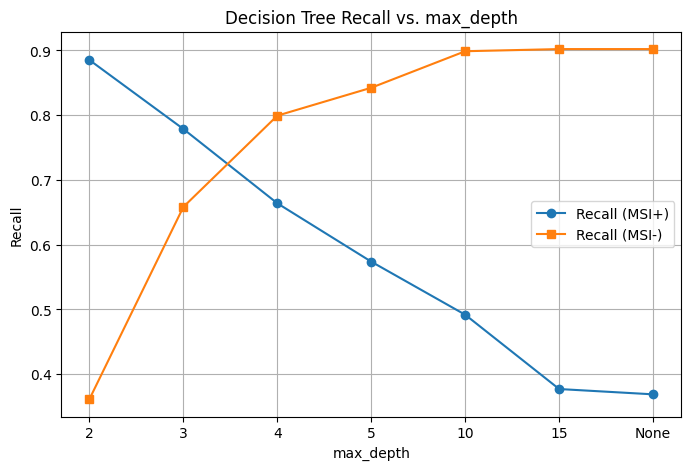


Confusion Matrix for max_depth=2:
[[218 385]
 [ 14 108]]

Confusion Matrix for max_depth=3:
[[397 206]
 [ 27  95]]

Confusion Matrix for max_depth=4:
[[482 121]
 [ 41  81]]

Confusion Matrix for max_depth=5:
[[508  95]
 [ 52  70]]

Confusion Matrix for max_depth=10:
[[542  61]
 [ 62  60]]

Confusion Matrix for max_depth=15:
[[544  59]
 [ 76  46]]

Confusion Matrix for max_depth=None:
[[544  59]
 [ 77  45]]


In [23]:
n_folds = 5
max_depth_values = [2, 3, 4, 5, 10, 15, None]

recall_pos_scores = []  # recall for MSI+
recall_neg_scores = []  # recall for MSI- (specificity)
conf_matrices = {}

for depth in max_depth_values:
    y_probs_all = []
    y_true_all = []

    for fold in range(n_folds):
        fold_key = f"fold_{fold}"
        X_train = fold_data[fold]["X_train"]
        y_train = fold_data[fold]["y_train"]
        X_val   = fold_data[fold]["X_val"]
        y_val   = fold_data[fold]["y_val"]

        dt = DecisionTreeClassifier(max_depth=depth, class_weight="balanced", random_state=42)
        dt.fit(X_train, y_train)

        y_prob = dt.predict_proba(X_val)[:, 1]  # probability of MSI+
        y_probs_all.append(y_prob)
        y_true_all.append(y_val)

    # concatenate all folds for averaging
    y_probs_all = np.concatenate(y_probs_all)
    y_true_all = np.concatenate(y_true_all)
    
    # apply decision threshold
    y_pred_avg = (y_probs_all >= 0.15).astype(int)

    # compute recall for positive (MSI+) and negative (MSI-)
    recall_pos = recall_score(y_true_all, y_pred_avg, pos_label=1)
    recall_neg = recall_score(y_true_all, y_pred_avg, pos_label=0)

    recall_pos_scores.append(recall_pos)
    recall_neg_scores.append(recall_neg)

    # save confusion matrix for later inspection
    conf_matrices[depth] = confusion_matrix(y_true_all, y_pred_avg)

# Plot recall curves
plt.figure(figsize=(8, 5))
plt.plot([str(d) for d in max_depth_values], recall_pos_scores, marker="o", label="Recall (MSI+)")
plt.plot([str(d) for d in max_depth_values], recall_neg_scores, marker="s", label="Recall (MSI-)")
plt.xlabel("max_depth")
plt.ylabel("Recall")
plt.title("Decision Tree Recall vs. max_depth")
plt.legend()
plt.grid(True)
plt.show()

# Example confusion matrices at shallow vs deep trees
for depth in max_depth_values:
    print(f"\nConfusion Matrix for max_depth={depth}:")
    print(conf_matrices[depth])

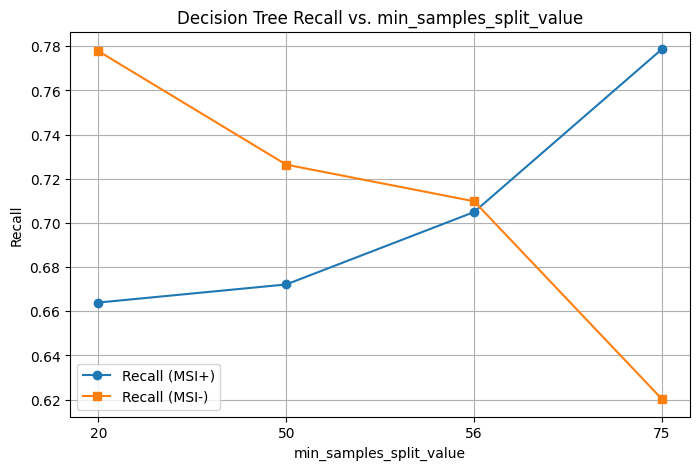


Confusion Matrix for min_samples_split_value=20:
[[469 134]
 [ 41  81]]

Confusion Matrix for min_samples_split_value=50:
[[438 165]
 [ 40  82]]

Confusion Matrix for min_samples_split_value=56:
[[428 175]
 [ 36  86]]

Confusion Matrix for min_samples_split_value=75:
[[374 229]
 [ 27  95]]


In [25]:
# decision tree, varying min_samples_split, max_depth= 4
n_folds = 5
min_samples_split_values = [20, 50, 56, 75]

recall_pos_scores = []  # recall for MSI+
recall_neg_scores = []  # recall for MSI- (specificity)
conf_matrices = {}

for min_samples_split_value in min_samples_split_values:
    y_probs_all = []
    y_true_all = []

    for fold in range(n_folds):
        fold_key = f"fold_{fold}"
        X_train = fold_data[fold]["X_train"]
        y_train = fold_data[fold]["y_train"]
        X_val   = fold_data[fold]["X_val"]
        y_val   = fold_data[fold]["y_val"]

        dt = DecisionTreeClassifier(max_depth=4, min_samples_split= min_samples_split_value, class_weight="balanced", random_state=42)
        dt.fit(X_train, y_train)

        y_prob = dt.predict_proba(X_val)[:, 1]  # probability of MSI+
        y_probs_all.append(y_prob)
        y_true_all.append(y_val)

    # concatenate all folds for averaging
    y_probs_all = np.concatenate(y_probs_all)
    y_true_all = np.concatenate(y_true_all)
    
    # apply decision threshold
    y_pred_avg = (y_probs_all >= 0.15).astype(int)

    # compute recall for positive (MSI+) and negative (MSI-)
    recall_pos = recall_score(y_true_all, y_pred_avg, pos_label=1)
    recall_neg = recall_score(y_true_all, y_pred_avg, pos_label=0)

    recall_pos_scores.append(recall_pos)
    recall_neg_scores.append(recall_neg)

    # save confusion matrix for later inspection
    conf_matrices[min_samples_split_value] = confusion_matrix(y_true_all, y_pred_avg)

# Plot recall curves
plt.figure(figsize=(8, 5))
plt.plot([str(d) for d in min_samples_split_values], recall_pos_scores, marker="o", label="Recall (MSI+)")
plt.plot([str(d) for d in min_samples_split_values], recall_neg_scores, marker="s", label="Recall (MSI-)")
plt.xlabel("min_samples_split_value")
plt.ylabel("Recall")
plt.title("Decision Tree Recall vs. min_samples_split_value")
plt.legend()
plt.grid(True)
plt.show()

# Example confusion matrices at shallow vs deep trees
for min_samples_split_value in min_samples_split_values:
    print(f"\nConfusion Matrix for min_samples_split_value={min_samples_split_value}:")
    print(conf_matrices[min_samples_split_value])

In [26]:
# decision tree, retraining and testing on test set
X_train_full = np.concatenate([fold["X_train"] for fold in fold_data], axis=0)
y_train_full = np.concatenate([fold["y_train"] for fold in fold_data], axis=0)
# 2️⃣ Train the final model on all training data
final_model = DecisionTreeClassifier(max_depth=4, min_samples_split= 56, class_weight="balanced", random_state=42)
final_model.fit(X_train_full, y_train_full)

# 3️⃣ Evaluate on the hold-out test set
y_prob_test = final_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_prob_test >= 0.15).astype(int)  # threshold can be adjusted

# 4️⃣ Metrics
print("Final Model Evaluation on Hold-out Test Set")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.3f}")
print(f"ROC-AUC:  {roc_auc_score(y_test, y_prob_test):.3f}")
print(f"Recall (MSI+): {recall_score(y_test, y_pred_test, pos_label=1):.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

Final Model Evaluation on Hold-out Test Set
Accuracy: 0.703
ROC-AUC:  0.625
Recall (MSI+): 0.581

Confusion Matrix:
[[110  41]
 [ 13  18]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.73      0.80       151
         1.0       0.31      0.58      0.40        31

    accuracy                           0.70       182
   macro avg       0.60      0.65      0.60       182
weighted avg       0.79      0.70      0.73       182



In [8]:
df

,TMA_XY,X,Y,ID,TMA.x,fnm,TMA.y,coor,level,coorX,coorY,coorXY,tumor,data_id,msin
0,TMA1_1_10,1,10,T82-4T,TMA1,"TMA 1 Level 16_Core[1,1,10]_[4381,47584].tif",TMA1,1_10,16,1,10,1_10,82,"TMA 1 Level 16_Core[1,1,10]_[4381,47584]",0.0
1,TMA1_1_10,1,10,T82-4T,TMA1,"TMA 1 Level 1_Core[1,1,10]_[3229,44466].tif",TMA1,1_10,1,1,10,1_10,82,"TMA 1 Level 1_Core[1,1,10]_[3229,44466]",0.0
2,TMA1_1_12,1,12,T97-1T,TMA1,"TMA 1 Level 1_Core[1,1,12]_[3031,46487].tif",TMA1,1_12,1,1,12,1_12,97,"TMA 1 Level 1_Core[1,1,12]_[3031,46487]",0.0
3,TMA1_1_12,1,12,T97-1T,TMA1,"TMA 1 Level 16_Core[1,1,12]_[4134,49464].tif",TMA1,1_12,16,1,12,1_12,97,"TMA 1 Level 16_Core[1,1,12]_[4134,49464]",0.0
4,TMA1_1_13,1,13,T104-2T,TMA1,"TMA 1 Level 1_Core[1,1,13]_[3344,47029].tif",TMA1,1_13,1,1,13,1_13,104,"TMA 1 Level 1_Core[1,1,13]_[3344,47029]",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2950,TMA6_9_13,9,13,T1782,TMA6,"TMA 6 Level 1_Core[1,9,13]_[7794,43876].tif",TMA6,9_13,1,9,13,9_13,1782,"TMA 6 Level 1_Core[1,9,13]_[7794,43876]",0.0
2951,TMA6_9_2,9,2,T1749,TMA6,"TMA 6 Level 1_Core[1,9,2]_[17735,43950].tif",TMA6,9_2,1,9,2,9_2,1749,"TMA 6 Level 1_Core[1,9,2]_[17735,43950]",0.0
2952,TMA6_9_3,9,3,T1753,TMA6,"TMA 6 Level 1_Core[1,9,3]_[16820,43975].tif",TMA6,9_3,1,9,3,9_3,1753,"TMA 6 Level 1_Core[1,9,3]_[16820,43975]",0.0
2953,TMA6_9_7,9,7,T1760,TMA6,"TMA 6 Level 1_Core[1,9,7]_[13284,43876].tif",TMA6,9_7,1,9,7,9_7,1760,"TMA 6 Level 1_Core[1,9,7]_[13284,43876]",0.0


In [22]:
pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_columns')

In [25]:
# checking features structure
features_dir= "/home/jantao/MSI_prediction/conch_patches/20x_256px_0px_overlap/features_conch_v15"
slide_id= "TMA 1 Level 16_Core[1,1,10]_[4381,47584]"
feature_path = os.path.join(features_dir, f"{slide_id}.h5")
with h5py.File(feature_path, "r") as f:
    print("Top-level keys:", list(f.keys()))
    for key in f.keys():
        print(f"{key} -> shape: {f[key].shape}, dtype: {f[key].dtype}")

Top-level keys: ['coords', 'features']
coords -> shape: (9, 2), dtype: int64
features -> shape: (9, 768), dtype: float32


In [19]:
image_name= "/data_g1/AI_projects/raw_data/PCITB_CRC/HE_raw_images/Tumor/TMA 12/TMA 12 Level 1_Core[1,19,2]_[19157,36297].tif"
im = Image.open(image_name)
print(im)

FileNotFoundError: [Errno 2] No such file or directory: '/data_g1/AI_projects/raw_data/PCITB_CRC/HE_raw_images/Tumor/TMA 12/TMA 12 Level 1_Core[1,19,2]_[19157,36297].tif'

In [30]:

def debug_path(path):
    # Ensure we are working with absolute path
    path = os.path.abspath(path)
    parts = path.split(os.sep)
    
    # Start from the root
    current = os.sep
    for p in parts[1:]:  # skip the empty string before first '/'
        current = os.path.join(current, p)
        if os.path.exists(current):
            print(f"✅ Exists: {current}")
        else:
            print(f"❌ Missing: {current}")
            break

# Example usage
image_path= "/data_g1/AI_projects/raw_data/PCITB_CRC/HE_raw_images/Tumor/TMA2/TMA 2 Level 1_Core[2,6,10]_[12602,42576]"
debug_path(image_path)

✅ Exists: /data_g1
✅ Exists: /data_g1/AI_projects
✅ Exists: /data_g1/AI_projects/raw_data
✅ Exists: /data_g1/AI_projects/raw_data/PCITB_CRC
✅ Exists: /data_g1/AI_projects/raw_data/PCITB_CRC/HE_raw_images
✅ Exists: /data_g1/AI_projects/raw_data/PCITB_CRC/HE_raw_images/Tumor
✅ Exists: /data_g1/AI_projects/raw_data/PCITB_CRC/HE_raw_images/Tumor/TMA2
❌ Missing: /data_g1/AI_projects/raw_data/PCITB_CRC/HE_raw_images/Tumor/TMA2/TMA 2 Level 1_Core[2,6,10]_[12602,42576]


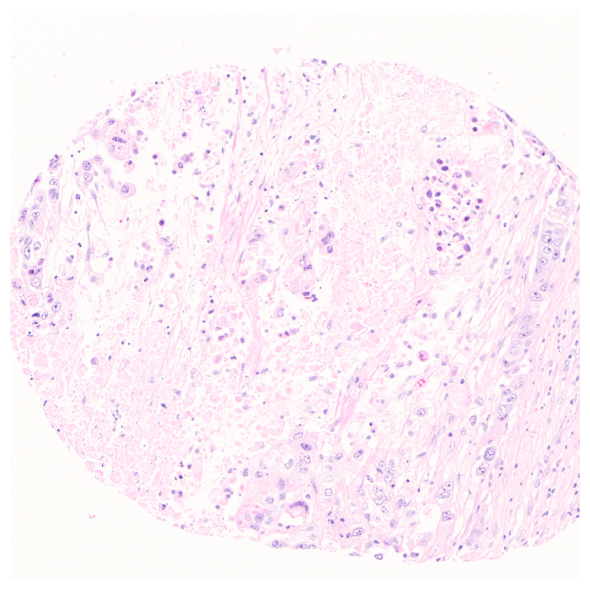

In [28]:
image_path = "/data_g1/AI_projects/raw_data/PCITB_CRC/HE_raw_images/Tumor/TMA12/TMA 12 Level 1_Core[1,19,2]_[19157,36297].tif"
im = Image.open(image_path)
fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(im)
ax.axis("off")
plt.tight_layout()
plt.show()

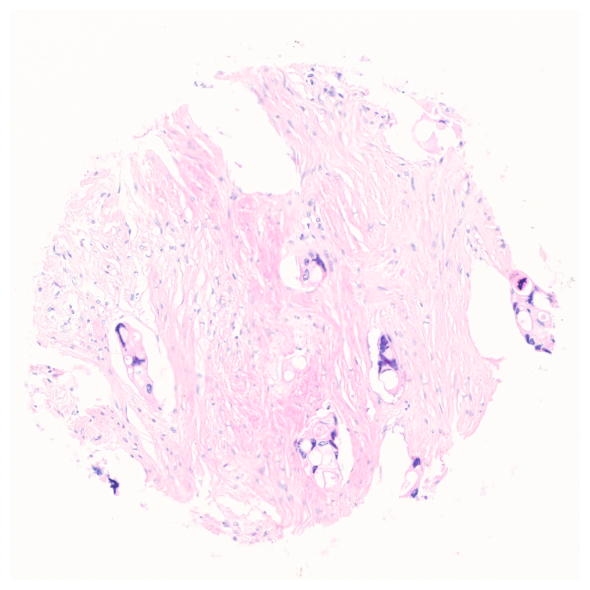

In [31]:
image_path= "/data_g1/AI_projects/raw_data/PCITB_CRC/HE_raw_images/Tumor/TMA2/TMA 2 Level 1_Core[2,6,10]_[12602,42576].tif"
im = Image.open(image_path)
fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(im)
ax.axis("off")
plt.tight_layout()
plt.show()